# Clean and merge data

**This section cleans and merges activity data from BigQuery and investment portfolio data from MySQL into one data frame.**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from targetandmarket.config import data_folder

In [3]:
# Import app activity data
# Note that session numbers and engagement times have been scaled by a hidden factor to obfuscate true values
user_analytics_raw = pd.read_csv(data_folder/'user_analytics_raw.csv', index_col=0)
user_error = pd.read_csv(data_folder/'user_error_status.csv', index_col=0)
timeseries = pd.read_csv(data_folder/'timeseries.csv', index_col=0)

**Let's look at the activity data which I queried from BigQuery**

In [4]:
print(user_analytics_raw.shape)

(173344, 6)


In [5]:
user_analytics_raw.head()

,user_id,sessions,last_session,total_time,avg_session,first_open
0,129682562,65,1.590957e+09,5236.317,80.558723,1.524686e+09
1,201385452,41,1.590787e+09,2354.798,57.434098,1.588205e+09
2,1558824692,79,1.590962e+09,9315.622,117.919266,1.580936e+09
3,118978210,75,1.590777e+09,5122.445,68.299267,1.531505e+09
4,701136272,30,1.590686e+09,8831.959,294.398633,1.579424e+09


**I have queried:**
* user_id: obfuscated user ID
* sessions: total number of sessions
* last_session: unix timestamp of last session (seconds)
* total_time: total engagement time
* avg_session: average session time
* first_open: unix timestamp of when app was first opened

**Session numbers were absent for some users so any user which such a session is removed**

In [6]:
user_analytics = user_analytics_raw.loc[~user_analytics_raw['user_id'].
                                        isin(user_error['user_id'])].copy()
print(user_analytics.shape)

(172493, 6)


**Since I am interested in predicting which users are paying users based on activity from May 2020, I need to exclude those users that started using the app in the middle of May 2020**

In [7]:
# Users who started using the app since app launch and 01 May 2020 are selected
PERIOD_START = pd.Timestamp('2017-11-01').timestamp()
PERIOD_END = pd.Timestamp('2020-05-01').timestamp()
user_analytics = user_analytics.loc[
    (user_analytics['first_open'] >= PERIOD_START)
    & (user_analytics['first_open'] < PERIOD_END)].copy()
print('Number of users between analysis duration:', len(user_analytics))

Number of users between analysis duration: 135674


**Converting unix timestamps to "delta" between June 01, 2020 (in terms of number of days ago)**

In [8]:
LAST_MODIFIED = 1590969600
user_analytics.loc[:, 'last_session'] = (
    (LAST_MODIFIED - user_analytics['last_session']) / (60 * 60 * 24))
user_analytics.loc[:, 'first_open'] = (
    (LAST_MODIFIED - user_analytics['first_open']) / (60 * 60 * 24))
user_analytics = user_analytics.astype('float64')

**Calculating the number of days a user was active in May 2020 from timeseries data**

In [9]:
timeseries = timeseries.pivot(index='user_id',
                              columns='date',
                              values='day_eng_time')
active_days = pd.notna(timeseries).sum(axis=1)
active_days.name = 'active_days'

user_analytics = pd.merge(user_analytics,
                          active_days,
                          how='inner',
                          on='user_id')

In [15]:
user_analytics.head()

,user_id,sessions,last_session,total_time,avg_session,first_open,active_days
0,1.296826e+08,65.0,0.149734,5236.317,80.558723,767.166667,29
1,2.013855e+08,41.0,2.115601,2354.798,57.434098,32.000000,21
2,1.558825e+09,79.0,0.087216,9315.622,117.919266,116.125000,28
3,1.189782e+08,75.0,2.224022,5122.445,68.299267,688.250000,24
4,7.011363e+08,30.0,3.279432,8831.959,294.398633,133.625000,24


**Now let's look at the investment data and our label (free vs paying user)**

In [11]:
user_holdings = pd.read_csv(data_folder/'user_holdings.csv')
user_purchases = pd.read_csv(data_folder/'user_purchases_may.csv', index_col=0)
user_purchases_june = pd.read_csv(data_folder/'user_purchases_early_june.csv', index_col=0)
user_transactions = pd.read_csv(data_folder/'user_transactions.tsv', sep='\t')

In [17]:
user_transactions.head()

,obfuscatedId,isPro,status,numberOfTransactions,numberOfCoins,numberOfCoinIds
0,671119916,1,ACTIVE,138,25,3
1,936520911,0,ACTIVE,4,2,2
2,44359534,1,ACTIVE,3,2,0
3,399029160,1,ACTIVE,236,20,9
4,2000673413,0,ACTIVE,3,3,0


In [18]:
#%% Merge number of transactions and number of coins with user analytics
user_analytics = pd.merge(user_analytics,
                          user_transactions[['obfuscatedId', 'numberOfTransactions', 'numberOfCoins']],
                          how='inner',
                          left_on='user_id',
                          right_on='obfuscatedId')
user_analytics = user_analytics.drop(['obfuscatedId'], axis=1)

In [19]:
user_holdings.head()

,obfuscatedId,isPro,status,holdings
0,671119916,1,ACTIVE,5.691166e+04
1,44359534,1,ACTIVE,2.117894e+05
2,399029160,1,ACTIVE,6.593942e+06
3,1123126564,0,ACTIVE,2.902064e+03
4,585372673,1,ACTIVE,4.058743e+04


In [20]:
user_holdings.describe()

,obfuscatedId,isPro,holdings
count,5.987670e+05,598767.000000,5.987670e+05
mean,1.072973e+09,0.010647,2.856173e+04
std,6.200869e+08,0.102633,3.261341e+05
min,1.236400e+04,0.000000,1.000008e+01
25%,5.358361e+08,0.000000,1.399821e+02
50%,1.072323e+09,0.000000,6.370056e+02
75%,1.610847e+09,0.000000,3.379418e+03
max,2.147482e+09,1.000000,9.985458e+06


**There are some outliers when it comes to holdings (value of investment portfolio). There are some users with negative holdings and some with holdings greater than the market capitalization of all digital assets. So I will only keep users with more than 10 USD value and less than 10 million USD**

In [21]:
user_holdings = user_holdings.loc[(user_holdings.holdings < 10000000)
                                  & (user_holdings.holdings > 10)]

In [22]:
# Merge with activity data
user_analytics = pd.merge(user_analytics,
                          user_holdings[['obfuscatedId', 'holdings', 'isPro']],
                          how='inner',
                          left_on='user_id',
                          right_on='obfuscatedId')
user_analytics = user_analytics.drop(['obfuscatedId'], axis=1)

**The isPro column indicates which user is currently a "PRO" or premium user. It also includes users who are on free trial (7 days) so these are actually free users and I need to change the label to 0**

In [23]:
# Purchase history from May 2020
user_purchases = user_purchases.dropna()
user_purchases = user_purchases.drop(['event_name'], axis=1)

mapping = {
    'io.getdelta.android.delta_pro_yearly_trial': 0,
    'io.getdelta.ios.DELTA_PRO_EARLY_BACKER_MONTHLY': 1,
    'io.getdelta.ios.DELTA_PRO_YEARLY_TRIAL': 0,
    'io.getdelta.ios.DELTA_PRO_EARLY_BACKER_MONTHLY_EQUALIZED': 1,
    'io.getdelta.ios.DELTA_PRO_EARLY_BACKER_YEARLY': 1,
    'io.getdelta.android.delta_pro_early_backer_yearly_equalized': 1
}

user_purchases.loc[:, 'product_id'] = user_purchases['product_id'].map(mapping)
user_purchases = user_purchases.sort_values(by=['user_id', 'product_id'])
# Keep last product "purchased" because those that actually purchased premium after trial should be left as is
user_purchases = user_purchases.drop_duplicates(subset=['user_id'],
                                                keep='last')
user_analytics = pd.merge(user_analytics,
                          user_purchases,
                          how='left',
                          on='user_id')
# Users that have pro status = 1 but are on trial (product_id ==0), set pro status as 0
user_analytics.loc[((user_analytics.isPro == 1) &
                    (user_analytics.product_id == 0)), 'isPro'] = 0
user_analytics = user_analytics.drop(['product_id'], axis=1)

**The isPro status is as of June 03, 2020. Due to the way the company stores data, historical status of isPro is not available. Therefore, I have used purchase history on June 01, 02 and 03 to set users that purchased premium during these days as non-premium for May 2020**

In [24]:
user_purchases_june = user_purchases_june.drop(['event_name'], axis=1)
user_purchases_june = user_purchases_june.dropna()
user_purchases_june.loc[:, 'product_id'] = user_purchases_june['product_id'].map(mapping)
user_purchases_june = user_purchases_june.sort_values(by=['user_id', 'product_id'])
user_purchases_june = user_purchases_june.drop_duplicates(subset=['user_id'], keep='last')
user_analytics = pd.merge(user_analytics, user_purchases_june, how='left', on='user_id')
# Set pro status for those who purchased or tried after June 01 as 0
user_analytics.loc[((user_analytics.isPro==1) & (~pd.isna(user_analytics.product_id))), 'isPro'] = 0
user_analytics = user_analytics.drop(['product_id'], axis=1)

In [25]:
user_analytics.head()

,user_id,sessions,last_session,total_time,avg_session,first_open,active_days,numberOfTransactions,numberOfCoins,holdings,isPro
0,1.296826e+08,65.0,0.149734,5236.317,80.558723,767.166667,29,34,24,8778.301834,0
1,1.558825e+09,79.0,0.087216,9315.622,117.919266,116.125000,28,118,20,2739.913695,0
2,1.189782e+08,75.0,2.224022,5122.445,68.299267,688.250000,24,11,10,354.697827,0
3,1.691281e+09,26.0,0.184756,1791.426,68.901000,99.041667,19,119,18,4000.690597,0
4,4.059957e+08,195.0,0.095354,13298.463,68.197246,376.416667,31,1038,14,178797.427788,1


In [27]:
#%% Save processed data
user_analytics.to_csv(data_folder/'user_analytics.csv')

# Exploration

In [28]:
user_data = pd.read_csv(data_folder/'user_analytics.csv', index_col=0)
user_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106983 entries, 0 to 106982
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   user_id               106983 non-null  float64
 1   sessions              106983 non-null  float64
 2   last_session          106983 non-null  float64
 3   total_time            106983 non-null  float64
 4   avg_session           106983 non-null  float64
 5   first_open            106983 non-null  float64
 6   active_days           106983 non-null  int64  
 7   numberOfTransactions  106983 non-null  int64  
 8   numberOfCoins         106983 non-null  int64  
 9   holdings              106983 non-null  float64
 10  isPro                 106983 non-null  int64  
dtypes: float64(7), int64(4)
memory usage: 9.8 MB


## Exploration

**Let's look at the label (free or paying user)**

0    103022
1      3961
Name: isPro, dtype: int64


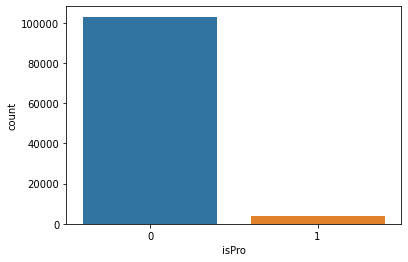

In [29]:
print(user_data.isPro.value_counts())
sns.countplot(user_data.isPro);

**Classes are heavily imbalanced as expected. Only around 3 to 4% users are paying users.**

**Now let's look at the features**

In [31]:
user_data.describe()

,user_id,sessions,last_session,total_time,avg_session,first_open,active_days,numberOfTransactions,numberOfCoins,holdings,isPro
count,1.069830e+05,106983.000000,106983.000000,106983.000000,106983.000000,106983.000000,106983.000000,106983.000000,106983.000000,1.069830e+05,106983.000000
mean,1.073834e+09,29.500827,7.566145,2301.867718,63.583109,468.369907,10.195975,194.506800,14.486507,2.882569e+04,0.037025
std,6.191869e+08,54.657689,8.676141,6852.649534,73.499378,281.342064,10.276373,1642.139111,20.758112,2.627479e+05,0.188823
min,1.562000e+04,1.000000,0.083335,10.001000,10.001000,31.041667,1.000000,1.000000,1.000000,1.001104e+01,0.000000
25%,5.373065e+08,2.000000,0.531571,76.483500,26.231043,215.125000,2.000000,7.000000,4.000000,4.472162e+02,0.000000
50%,1.073229e+09,6.000000,3.406444,292.221000,42.052462,436.583333,5.000000,22.000000,8.000000,2.022098e+03,0.000000
75%,1.610456e+09,28.000000,13.117607,1393.364500,72.972571,742.083333,17.000000,80.000000,17.000000,9.184168e+03,0.000000
max,2.147438e+09,537.000000,31.083196,167764.425000,1744.580000,942.958333,31.000000,150646.000000,399.000000,9.950672e+06,1.000000


In [32]:
def plot_corr_map(data):
    f, ax = plt.subplots(figsize=(10, 6))
    corr = data.corr()
    hm = sns.heatmap(round(corr, 2),
                     annot=True,
                     ax=ax,
                     cmap="coolwarm",
                     fmt='.2f',
                     linewidths=.05,
                    center=0)
    f.subplots_adjust(top=0.93)
    t = f.suptitle('User Data Correlation Heatmap', fontsize=16)
    return f

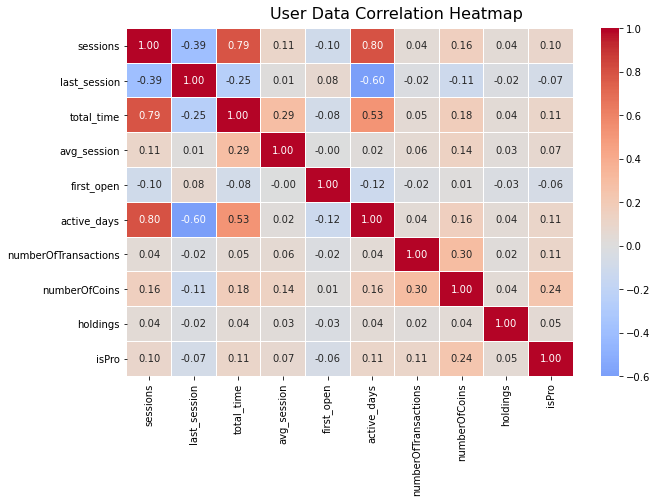

In [33]:
fig1 = plot_corr_map(user_data.drop(['user_id'], axis=1))

**Some features are significantly correlated with each other such as sessions, total_time and active_days. Number of transactions and number of coins are also slightly correlated. We will look more closely at these during feature selection.**